Gradient Boosting Classifier

Import libraries

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

import sys
import os

# Get the current working directory (which should be the directory containing the Jupyter notebook)
current_dir = os.getcwd()

# Construct the absolute path to the DataPreprocessing directory
data_preprocessing_path = os.path.join(current_dir, '..', 'DataPreprocessing')

# Add this path to sys.path
sys.path.append(os.path.abspath(data_preprocessing_path))

# Import custom preprocessing functions
from Preprocessing import filter_data, FeatureExtract

Read and Preprocess data

In [9]:
# Initialize empty DataFrame for features and an empty array for labels
X = pd.DataFrame()
y = np.array([])

# Define the files and corresponding labels
files = {("ThaiBuon.txt", -1), ("ThaiVui.txt", 1), ("ThaiVui2.txt", 1), 
         ("ThaiCalm2.txt", 0), ("ThaiCalm.txt", 0), ("BachBuon.txt", 0), 
         ("ThanhfBuon.txt", -1), ("ThanhfVui.txt", 1), ("BachCalm.txt", 0), 
         ("SonBuon3.txt", -1), ("SonVui4.txt", 1), ("QuangCalm3.txt", 0),
         ("SonBuon4.txt", -1), ("ThanhfCalm.txt", 0), ("ThanhfVui2.txt", 1), 
         ("QuangBuon.txt", -1)}

# Load and preprocess each file
for filename, label in files:
    raw_data = np.loadtxt("../CollectedData/new_data/" + filename)
    
    # Preprocessing: Filter noise & use Short-time Fourier Transform
    raw_data = filter_data(raw_data)
    data = FeatureExtract(raw_data, plot=0)
    data_df = pd.DataFrame.from_dict(data)
    X = pd.concat([X, data_df], ignore_index=True)
    y = np.append(y, np.array([label] * data_df.shape[0]))

# Convert features to numpy array
X = X.values

Create the MLP Classifier

In [10]:
### Create pipeline for standardization of data
model = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, max_depth=7))

Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 1.0
Test accuracy: 0.8875


              precision    recall  f1-score   support

          -1       0.88      0.82      0.85       136
           0       0.97      0.97      0.97       144
           1       0.81      0.88      0.84       120

    accuracy                           0.89       400
   macro avg       0.88      0.89      0.88       400
weighted avg       0.89      0.89      0.89       400



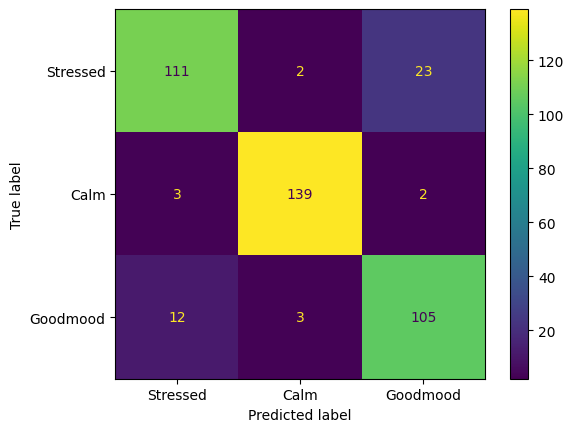

In [12]:
### Statistics and Confusion Matrix display
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[-1, 0, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Stressed", "Calm", "Goodmood"])
disp.plot()
plt.savefig("../Figure/Bach_GB")
plt.show()

K-Fold cross validation

In [13]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
accuracy_list = []
for train_index, test_index in kf.split(X, y):
    # Split data into training and testing sets
    X_train_kf, X_test_kf = X[train_index], X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    model.fit(X_train_kf, y_train_kf)
    
    accuracy = model.score(X_test_kf, y_test_kf)
    accuracy_list.append(accuracy)
    
avg_accuracy = np.mean(accuracy_list)
print("Accuracy of folds:", accuracy_list)
print("K-Fold mean accuracy:", avg_accuracy)

Accuracy of folds: [0.895, 0.88, 0.865, 0.91, 0.895, 0.92, 0.905, 0.9, 0.905, 0.885]
K-Fold mean accuracy: 0.8959999999999999


In [14]:
### Write model to file
model.fit(X, y)
pickle.dump(model, open("../trained_model/GradientBoosting.h5", "wb"))


In [ ]:
### Test on new data
# model.fit(X, y)
# files = {} # tuple(s) of file name and expected label (if any)
    
# for filename, label in files:
#     raw_data = np.loadtxt("CollectedData/new_data/" + filename)
#     data_df = pd.DataFrame.from_dict(FeatureExtract(raw_data, plot=0)).values
    
#     # Scale new data using StandardScaler fit on training data
#     data_df = scaler.transform(data_df)
#     y_pred = model.predict(data_df)
#     print("Real-time predictions:")
#     print(y_pred)
#     print("Accuracy:", accuracy_score(np.array([label] * y_pred.shape[0]), y_pred))